In [1]:
from pytomoatt.model import ATTModel
from pytomoatt.para import ATTPara
import pygmt
import numpy as np

/Users/xumijian/opt/miniconda3_arm/lib/python3.9/abc.py:106: FutureWarning: xarray subclass Dataset should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [7]:
final_model_file = './OUTPUT_FILES/OUTPUT_FILES_inv_abs/final_model.h5'
target_model_file = '../0_generate_files_for_TomoATT/2_models/model_ckb_N61_61_61.h5'
par_file = './input_params/input_params_inv_abs.yaml'
par = ATTPara(par_file)

model = ATTModel.read(final_model_file, par_file)
# model = ATTModel.read(target_model_file, par_file)
model.calc_dv(par.input_params['model']['init_model_path'])

all_dep = [10,30]
dv_dep = []
phi_dep = []
epsilon_dep = []
epsilon_dep_samp = []

for i, dep in enumerate(all_dep):
    da = model.to_xarray()
    dv_dep.append(da.interp_dep(dep, field='dlnv'))
    phi_dep.append(da.interp_dep(dep, field='phi', samp_interval=5))
    epsilon_dep.append(da.interp_dep(dep, field='epsilon'))
    epsilon_dep_samp.append(da.interp_dep(dep, field='epsilon', samp_interval=5))

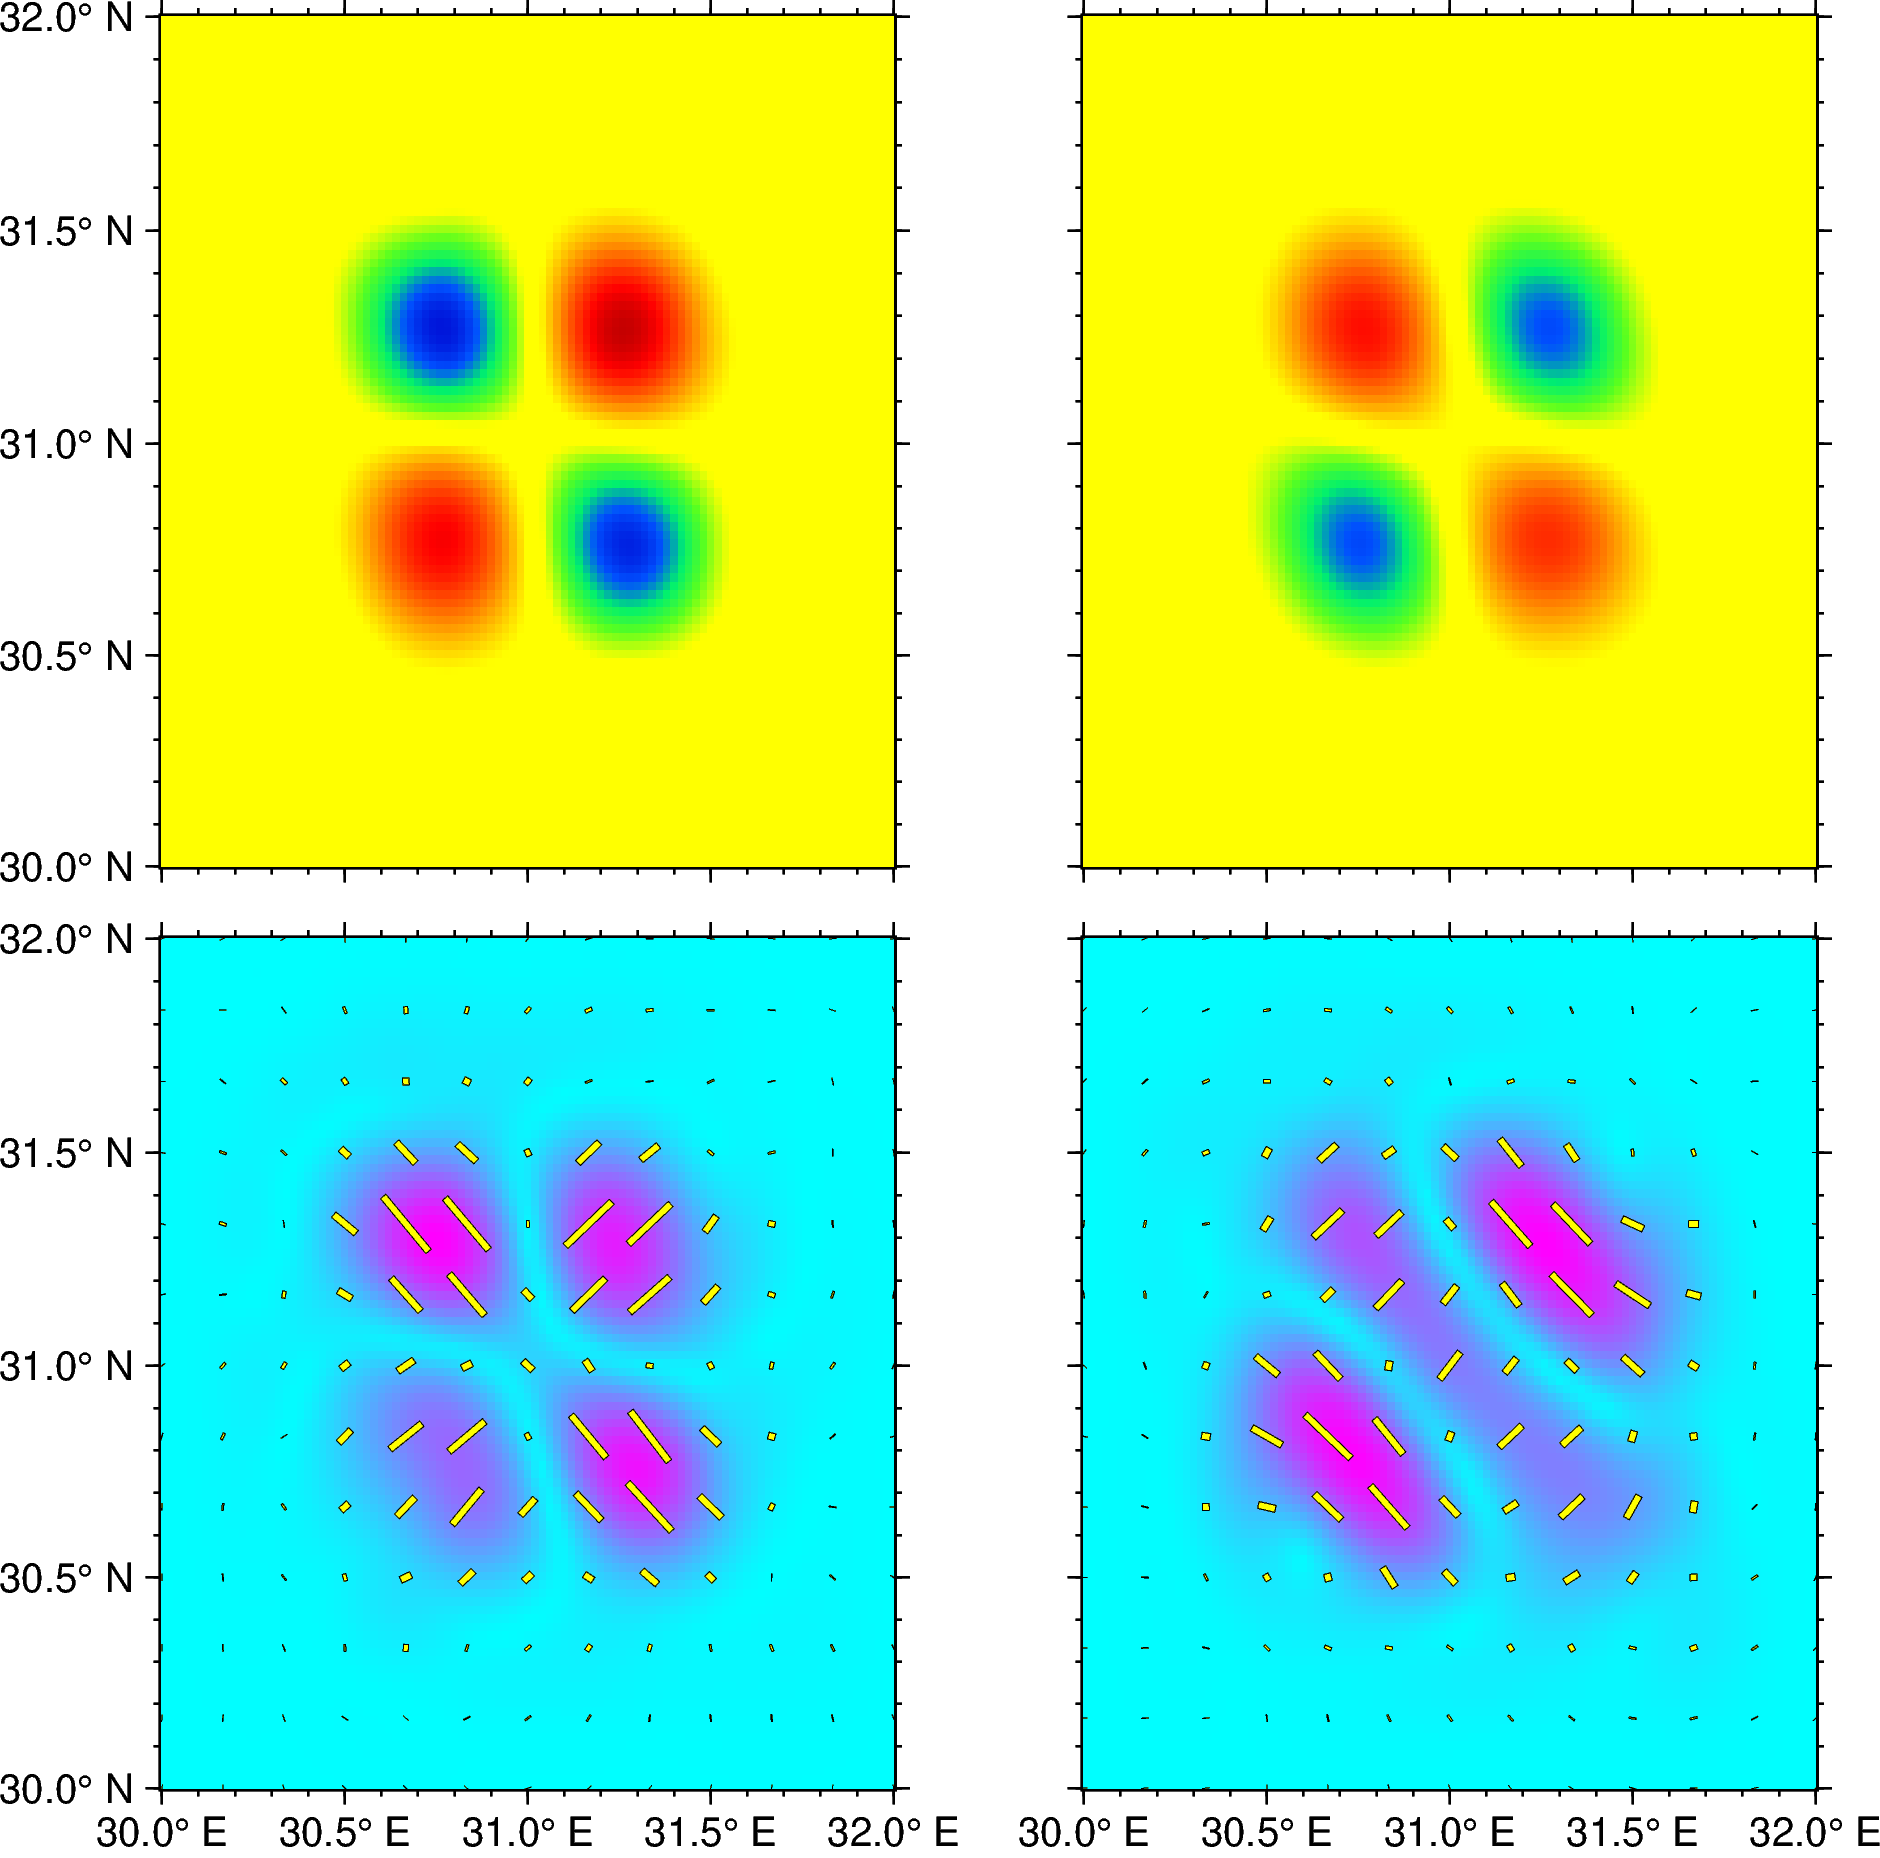

In [8]:
region = [
    par.input_params['domain']['min_max_lon'][0],
    par.input_params['domain']['min_max_lon'][1],
    par.input_params['domain']['min_max_lat'][0],
    par.input_params['domain']['min_max_lat'][1]
]

fig = pygmt.Figure()
with fig.subplot(nrows=len(all_dep), ncols=2, figsize=('15c', '15c'), sharex='b', sharey='l',  frame=['a0.5f0.1', 'WSne']):
    pygmt.config(MAP_FRAME_TYPE='plain', FORMAT_GEO_MAP='ddd.xG')
    pygmt.makecpt(cmap='seis', series=[-8, 8, 0.1], continuous=True)
    for i, dep in enumerate(all_dep):
        fig.basemap(region=region, projection='M?', panel=i)
        grid = pygmt.surface(region=region, x=dv_dep[i][:, 0], y=dv_dep[i][:, 1], z=dv_dep[i][:, 2], spacing='0.02')
        fig.grdimage(grid=grid, cmap=True)

    for i, dep in enumerate(all_dep):
        fig.basemap(region=region, projection='M?', panel=len(all_dep)+i)
        grid = pygmt.surface(region=region, x=epsilon_dep[i][:, 0], y=epsilon_dep[i][:, 1], z=epsilon_dep[i][:, 2], spacing='0.02')
        fig.grdimage(grid=grid, cmap='cool')
        ani = np.hstack([phi_dep[i], (epsilon_dep_samp[i][:, 2]*20).reshape(-1, 1), (np.ones(phi_dep[i].shape[0])*0.06).reshape(-1, 1)])
        fig.plot(ani, style='j', fill='yellow1', pen='0.1p,black')
fig.show()
